In [1]:
import sys
import math

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as utils
import torchvision.transforms as T
from torch.autograd import Variable
import pdb
import matplotlib.pyplot as plt

%matplotlib inline
torch.manual_seed(1)

In [2]:
USE_CUDA=torch.cuda.is_available()

In [120]:
class Policy(nn.Module):
    def __init__(self, hidden_size, num_inputs, action_space):
        super(Policy, self).__init__()
        self.action_space = action_space
        num_outputs = action_space.n

        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_outputs)

    def forward(self, inputs):
        x = inputs
        x = F.relu(self.linear1(x))
        action_scores = self.linear2(x)
        return F.softmax(action_scores)


class REINFORCE:
    def __init__(self, hidden_size, num_inputs, action_space):
        self.action_space = action_space
        self.model = Policy(hidden_size, num_inputs, action_space)
        self.model = self.model.cuda() if USE_CUDA else self.model
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.model.train()

    def select_action(self, state):
        probs = self.model(Variable(state).cuda()) if USE_CUDA else self.model(Variable(state))
        action = probs.multinomial().data
        prob = probs[:, action[0,0]].view(1, -1)
        log_prob = prob.log()
        entropy = - (probs*probs.log()).sum()
        return action[0][0], log_prob, entropy

    def update_parameters(self, rewards, log_probs, entropies, gamma):
        R = torch.zeros(1, 1)
        loss = 0
        for i in reversed(range(len(rewards))):
            R = gamma * R + rewards[i]
            sum_of_entropy = (0.0001*entropies[i].cuda()).sum() if USE_CUDA else (0.0001*entropies[i]).sum()
            sum_of_log_reward = (log_probs[i]*(Variable(R).expand_as(log_probs[i])).cuda()).sum() if USE_CUDA else (log_probs[i]*(Variable(R).expand_as(log_probs[i]))).sum()
            loss = loss - sum_of_log_reward - sum_of_entropy
        loss = loss / len(rewards)

        self.optimizer.zero_grad()
        loss.backward()
        utils.clip_grad_norm(self.model.parameters(), 40)
        self.optimizer.step()

In [87]:
env = gym.make('CartPole-v0')

[2017-07-14 18:21:21,454] Making new env: CartPole-v0


In [133]:
NUM_EPISODE=1000
GAMMA = 0.99
agent = REINFORCE(128,env.observation_space.shape[0],env.action_space)
reward_for_plot=[]

In [134]:
for i_episode in range(NUM_EPISODE):
    state = torch.Tensor([env.reset()])
    rewards=[]
    log_probs=[]
    entropies=[]

    while(1):
        action, log_prob, entropy =  agent.select_action(state)
        next_state, reward, done, _ = env.step(action)

        entropies.append(entropy)
        log_probs.append(log_prob)
        rewards.append(reward)
        state = torch.Tensor([next_state])
        
        if done:
            break
    
    agent.update_parameters(rewards, log_probs, entropies, GAMMA)
    if i_episode % 10 == 0:
        reward_for_plot.append(np.sum(rewards))
    if i_episode % 100 == 0:
        print("Episode: {}, reward: {}".format(i_episode, np.sum(rewards)))

Episode: 0, reward: 13.0
Episode: 100, reward: 22.0
Episode: 200, reward: 25.0
Episode: 300, reward: 51.0
Episode: 400, reward: 16.0
Episode: 500, reward: 56.0
Episode: 600, reward: 46.0
Episode: 700, reward: 919.0
Episode: 800, reward: 135.0
Episode: 900, reward: 147.0


(-4.9500000000000002, 103.95, 0, 200)

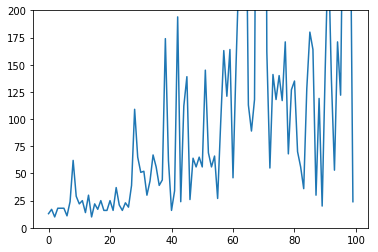

In [138]:
plt.plot(reward_for_plot)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,200))

In [141]:
log_prob

Variable containing:
1.00000e-02 *
 -4.2216
[torch.FloatTensor of size 1x1]

In [139]:
test = torch.zeros(1, 1)

In [142]:
test.expand_as(log_prob)


 0
[torch.FloatTensor of size 1x1]